# Bank Marketing: Our Data and Approach

The setting and goal of our Dataset was already described:  
  
Setting:  
_"The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed."_  

Goal:  
_"The classification goal is to predict if the client will subscribe (yes/no) a term deposit (variable y)."_  

## Nature of Data
First we looked at the Nature of the Data.  
[Nature of Data](Nature_of_Data_NEW.ipynb)  

Important findings were:  
  
  

## Testing different classification models

As first approach to learning, we tried diferent models.  
[Research Notebook](research.ipynb) with Data processing as well as some different approachaes. 



### Preprocessing
Before we did that however, we started by preprocessing the Data.
First, we imported the Data. There is a smaller Dataset with around 10% included in the Data, that we decided to use for the research process. (So we had more reasonable processing times)

Afterwards, we prepared the Data and encoded it, using a OneHot Encoder as well as a MinMaxScaler.


In [23]:
import pandas as pd
import itertools
import numpy as np
from sklearn import preprocessing
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import cross_val_predict
from sklearn.neural_network import MLPClassifier


In [3]:
bank_data = pd.read_csv("Data/bank-additional/bank-additional/bank-additional.csv", delimiter=";") #10 % of examples

bank_data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,30,blue-collar,married,basic.9y,no,yes,no,cellular,may,fri,...,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no
1,39,services,single,high.school,no,no,no,telephone,may,fri,...,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
2,25,services,married,high.school,no,yes,no,telephone,jun,wed,...,1,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,no
3,38,services,married,basic.9y,no,unknown,unknown,telephone,jun,fri,...,3,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,no
4,47,admin.,married,university.degree,no,yes,no,cellular,nov,mon,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,no


In [4]:
from sklearn.preprocessing import LabelEncoder

# Preprocessing of the target data
bank_target = bank_data['y']
bank_data = bank_data.drop(columns='y')

label = LabelEncoder()
bank_target = label.fit_transform(bank_target)
label_names=['no','yes'] # 0 = no, 1 = yes
label_order=label.transform(label_names)

preprocessor = ColumnTransformer(
    transformers=[
        # MinMaxScaler for numerical columns
        ('scaler', preprocessing.MinMaxScaler(), 
            ['age', 'duration', 'campaign', 'pdays', 'previous', 
            'emp.var.rate', 'cons.price.idx', 'cons.conf.idx',  
            'euribor3m', 'nr.employed']),
        # OneHotEncoder for categorical columns
        ('encoder', preprocessing.OneHotEncoder(handle_unknown='ignore'), 
            ['job','marital','education','default','housing',
             'loan','contact','month','day_of_week','poutcome'])])
print(bank_target)

[0 0 0 ... 0 0 0]


Pipelines:

In [24]:
# decision tree
dt_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('balancing', RandomUnderSampler()),
                              ('classifier', DecisionTreeClassifier())])

# random forest
rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('balancing', RandomUnderSampler()),
                              ('classifier', RandomForestClassifier())])

# k nearest neighbours
knn_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('balancing', RandomUnderSampler()),
                              ('classifier', KNeighborsClassifier())])

# multinomial naive bayes
mnb_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('balancing', RandomUnderSampler()),
                              ('classifier', MultinomialNB())])

# gaussian naive bayes
gnb_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('balancing', RandomUnderSampler()),
                              ('classifier', GaussianNB())])

# neural Network, MLP classifier
nn_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('balancing', RandomUnderSampler(random_state=42)),
                              ('classifier', MLPClassifier())])

Grid Search Parameters:

In [25]:
dt_param_grid =  { 'classifier__criterion':['gini','entropy'],
                   'classifier__max_depth': np.arange(3, 30)}

rf_param_grid =  {'classifier__n_estimators': [50, 100, 200, 500],
                  'classifier__max_features': ['sqrt','log2'], 
                  'classifier__max_depth' : [4,5,6,7,8,10,12,18,24],
                  'classifier__criterion' :['gini', 'entropy']}

knn_param_grid = {'classifier__n_neighbors': [3,5,10,15,20,25,30,40,50],
                  'classifier__weights': ['uniform', 'distance'],
                  'classifier__metric': ['euclidean', 'manhattan']}

mnb_param_grid = {'classifier__alpha': [0.5, 1.0, 1.5, 2.0],
                  'classifier__fit_prior': [True, False]}

gnb_param_grid = {'classifier__var_smoothing': np.logspace(0,-9, num=100)}

nn_param_grid = {
    'classifier__max_iter': [100, 250, 500],
    'classifier__tol': [0.001, 0.01, 0.1],
    'classifier__hidden_layer_sizes': [(50,50,50), (50,100,50), (100,100,100)],
    'classifier__activation': ['tanh', 'relu'],
    'classifier__solver': ['sgd', 'adam'],
    'classifier__alpha': [0.005, 0.05],
    'classifier__learning_rate': ['constant','adaptive'],
    'balancing__replacement': [True, False]
}

Plot Confusion Matrix Function(from class):

In [26]:
def plot_confusion_matrix(cm, 
                          classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
 
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
 
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
 
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Cost function and Matrix:

| Predict\Actual  | Subscribe (1) | Not Subscribe (0)    |
|-----------------|---------------|----------------------|
| Subscribe (1)   | 120 (Benefit)| 40 (Cost: Marketing) |
| Not Subscribe (0)| 100 (Cost: Lost Deal) | 0 (No Cost)          |

In [27]:
from sklearn.metrics import make_scorer


def cost_function(y_true, y_pred): 
    cm = confusion_matrix(y_true, y_pred, labels=label_order)    
    return cm[0][0] * 0 + cm[0][1] * 40 - cm[1][1] * 120 + cm[1][0] * 100

scorer = make_scorer(cost_function, greater_is_better=False)

Predict:

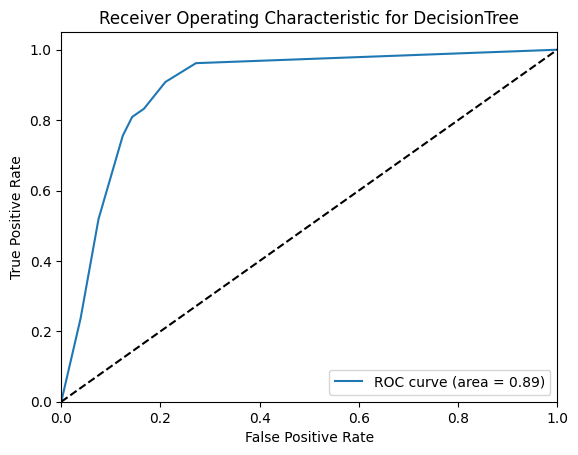


Best DecisionTree Classifier with parameters({'classifier__criterion': 'gini', 'classifier__max_depth': 3}): Accuracy of 0.8519417475728155 and cost -3900


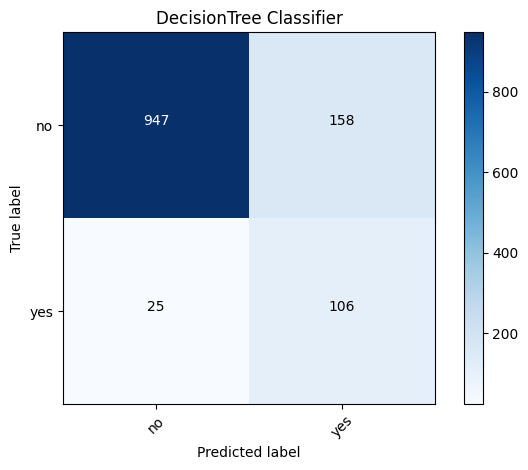

              precision    recall  f1-score   support

          no       0.97      0.86      0.91      1105
         yes       0.40      0.81      0.54       131

    accuracy                           0.85      1236
   macro avg       0.69      0.83      0.72      1236
weighted avg       0.91      0.85      0.87      1236



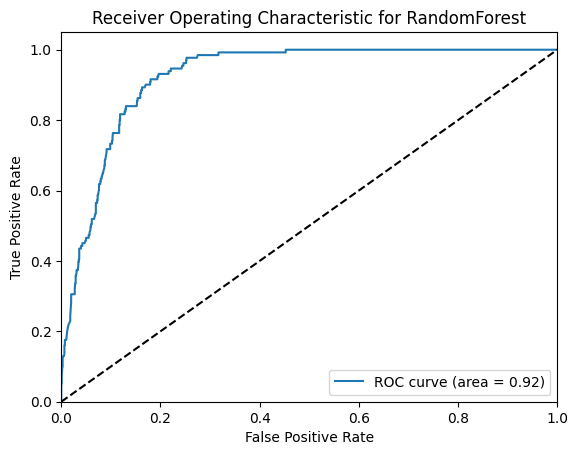


Best RandomForest Classifier with parameters({'classifier__criterion': 'gini', 'classifier__max_depth': 18, 'classifier__max_features': 'sqrt', 'classifier__n_estimators': 200}): Accuracy of 0.8446601941747572 and cost -5160


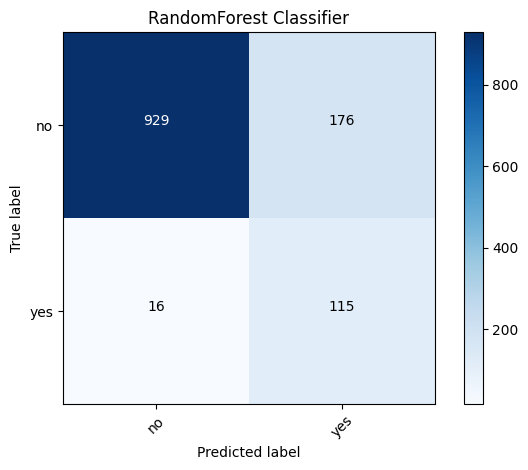

              precision    recall  f1-score   support

          no       0.98      0.84      0.91      1105
         yes       0.40      0.88      0.55       131

    accuracy                           0.84      1236
   macro avg       0.69      0.86      0.73      1236
weighted avg       0.92      0.84      0.87      1236



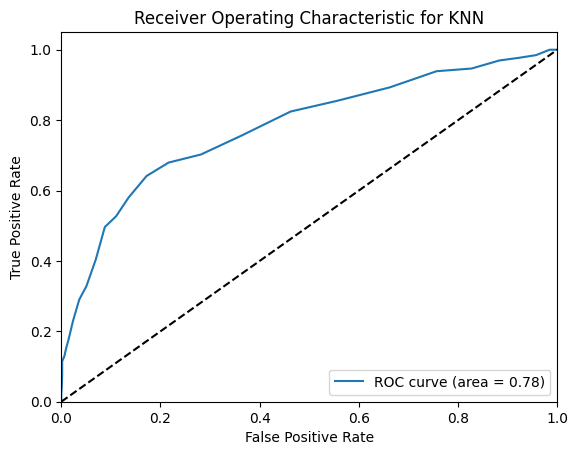


Best KNN Classifier with parameters({'classifier__metric': 'euclidean', 'classifier__n_neighbors': 30, 'classifier__weights': 'uniform'}): Accuracy of 0.8341423948220065 and cost 2380


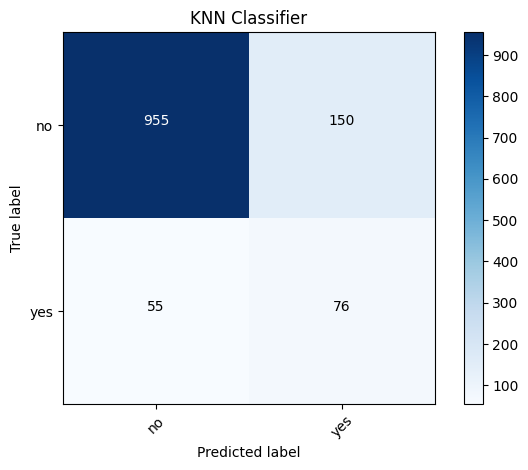

              precision    recall  f1-score   support

          no       0.95      0.86      0.90      1105
         yes       0.34      0.58      0.43       131

    accuracy                           0.83      1236
   macro avg       0.64      0.72      0.66      1236
weighted avg       0.88      0.83      0.85      1236



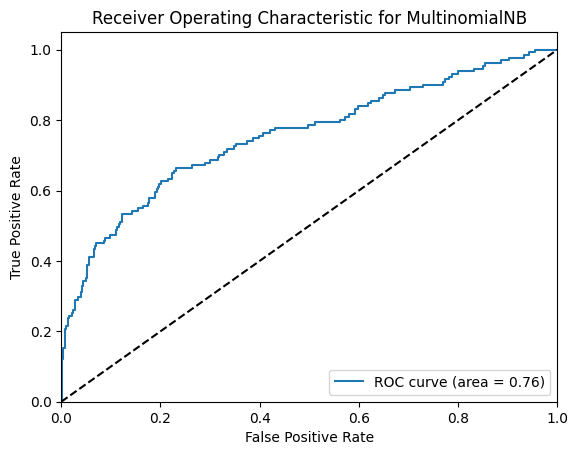


Best MultinomialNB Classifier with parameters({'classifier__alpha': 1.5, 'classifier__fit_prior': True}): Accuracy of 0.7694174757281553 and cost 4500


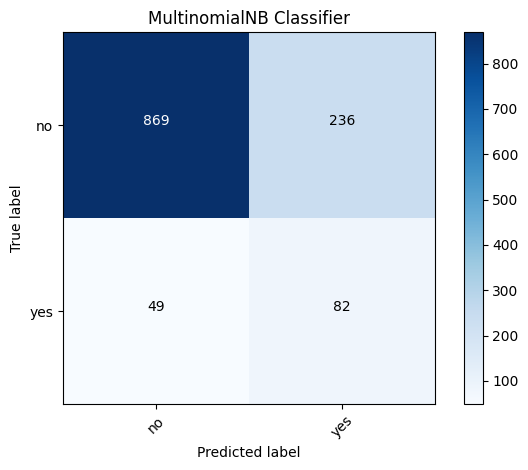

              precision    recall  f1-score   support

          no       0.95      0.79      0.86      1105
         yes       0.26      0.63      0.37       131

    accuracy                           0.77      1236
   macro avg       0.60      0.71      0.61      1236
weighted avg       0.87      0.77      0.81      1236



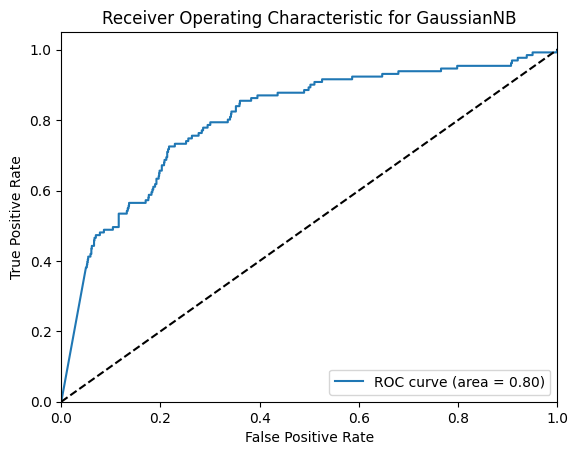


Best GaussianNB Classifier with parameters({'classifier__var_smoothing': 2.848035868435799e-05}): Accuracy of 0.7467637540453075 and cost 3100


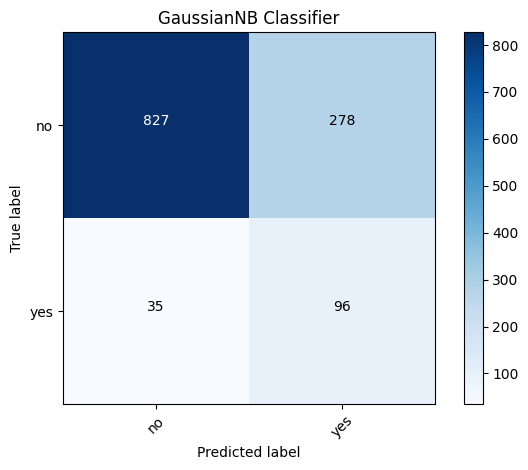

              precision    recall  f1-score   support

          no       0.96      0.75      0.84      1105
         yes       0.26      0.73      0.38       131

    accuracy                           0.75      1236
   macro avg       0.61      0.74      0.61      1236
weighted avg       0.88      0.75      0.79      1236



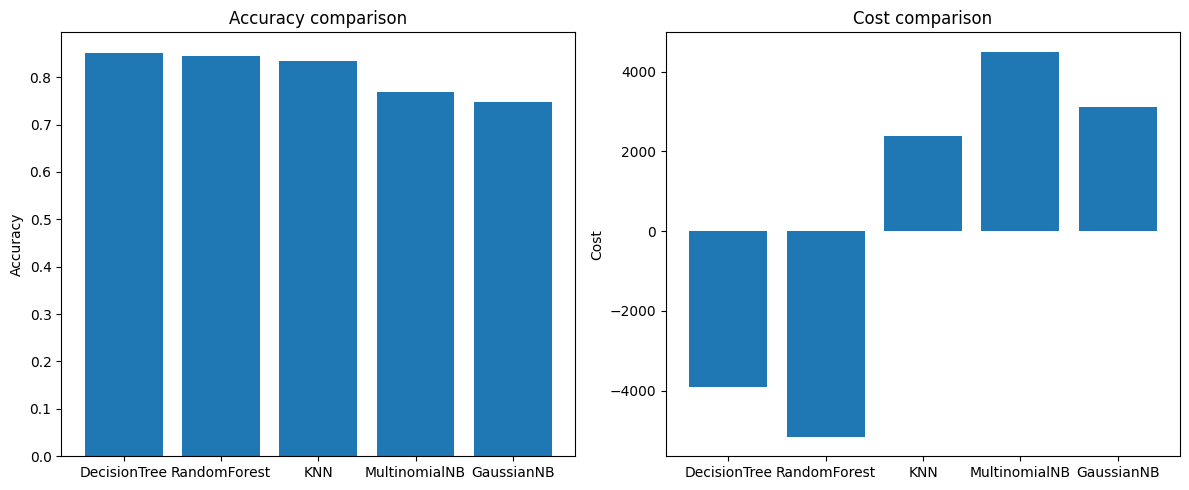

In [29]:
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV, train_test_split

# list of tuples where the first element is the classifier's name, the second is the classifier itself and the third are the grid search parameters
classifiers = [('DecisionTree', dt_pipeline, dt_param_grid),
               ('RandomForest', rf_pipeline, rf_param_grid),
               ('KNN', knn_pipeline, knn_param_grid),
               ('MultinomialNB', mnb_pipeline, mnb_param_grid),
               ('GaussianNB', gnb_pipeline, gnb_param_grid)]


# Initialize lists to store classifier names and their performances
names = []
accuracies = []
costs = []

# split into test and training data
bank_data_train, bank_data_test, bank_target_train, bank_target_test = train_test_split(bank_data, bank_target, test_size=0.3, random_state=42)

# Loop over the classifiers
for name, pipeline, param_grid in classifiers:
    # Grid search with parameter grid and cost function
    grid_search = GridSearchCV(pipeline, param_grid, cv=10, scoring=scorer, n_jobs=-1)
    grid_search.fit(bank_data_train, bank_target_train)
    
    # Get the best model
    best_model = grid_search.best_estimator_
    
    # Get the best parameters
    best_param = grid_search.best_params_
    
    # Make predictions with the best model
    prediction = best_model.predict(bank_data_test)

    # Calculate probabilities for the positive class
    probs = best_model.predict_proba(bank_data_test)[:, 1]
    
    # Calculate the ROC curve
    fpr, tpr, thresholds = roc_curve(bank_target_test, probs)
    
    # Calculate the AUC
    roc_auc = roc_auc_score(bank_target_test, probs)
    
    # Plot the ROC curve
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic for {}'.format(name))
    plt.legend(loc="lower right")
    plt.show()

    # Calculate accuracy and cost
    cm = confusion_matrix(bank_target_test, prediction)
    acc = accuracy_score(bank_target_test, prediction)
    cost = cost_function(bank_target_test, prediction)

    # Append the name and performance metrics to the lists
    names.append(name)
    accuracies.append(acc)
    costs.append(cost)
    
    # Plot Confusion Matrix for each classifier
    print("\nBest {} Classifier with parameters({}): Accuracy of {} and cost {}".format(name, best_param, acc, cost))
    plot_confusion_matrix(cm, classes=label_names, title='{} Classifier'.format(name))
    plt.show()
    print(classification_report(bank_target_test, prediction, target_names=label_names))

# Plotting comparison
plt.figure(figsize=(12,5))

# Subplot for accuracy
plt.subplot(121)  # 1 row, 2 columns, plot 1
plt.bar(names, accuracies)
plt.title('Accuracy comparison')
plt.ylabel('Accuracy')

# Subplot for cost
plt.subplot(122)  # 1 row, 2 columns, plot 2
plt.bar(names, costs)
plt.title('Cost comparison')
plt.ylabel('Cost')

plt.tight_layout()
plt.show()

## Further optimization of Random Forest


Best Random Forest Classifier with parameters({'balancing': RandomUnderSampler(), 'classifier__criterion': 'entropy', 'classifier__max_depth': 7, 'classifier__max_features': 'sqrt', 'classifier__n_estimators': 100}): Accuracy of 0.8414239482200647 and cost -5540


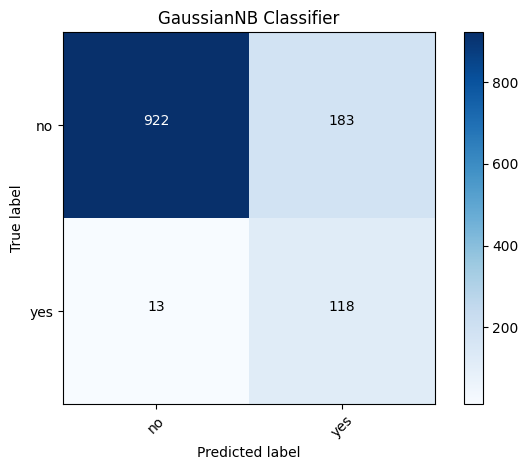

              precision    recall  f1-score   support

          no       0.99      0.83      0.90      1105
         yes       0.39      0.90      0.55       131

    accuracy                           0.84      1236
   macro avg       0.69      0.87      0.73      1236
weighted avg       0.92      0.84      0.87      1236



In [14]:
from sklearn.model_selection import GridSearchCV

#extending param grid for RF
param_grid = {
    'balancing': [RandomOverSampler(), RandomUnderSampler()],
    'classifier__n_estimators': [50, 100, 200, 300, 400],
    'classifier__max_features': ['sqrt', 'log2'],
    'classifier__max_depth': [4,5,6,7,8,10,12,18,24,30, None],
#    'classifier__min_samples_split': [2, 5, 10],
#    'classifier__min_samples_leaf': [1, 2, 4],
#    'classifier__bootstrap': [True, False],
    'classifier__criterion': ['gini', 'entropy']
}


# split into test and training data
bank_data_train, bank_data_test, bank_target_train, bank_target_test = train_test_split(bank_data, bank_target, test_size=0.3, random_state=42)

# Grid search with parameter grid and cost function
grid_search = GridSearchCV(rf_pipeline, param_grid, cv=10, scoring=scorer, n_jobs=-1)
grid_search.fit(bank_data_train, bank_target_train)

# Get the best model
best_model = grid_search.best_estimator_

# Get the best parameters
best_param = grid_search.best_params_

# Make predictions with the best model
prediction = best_model.predict(bank_data_test)

# Calculate probabilities for the positive class
probs = best_model.predict_proba(bank_data_test)[:, 1]

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(bank_target_test, probs)

# Calculate the AUC
roc_auc = roc_auc_score(bank_target_test, probs)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for {}'.format(name))
plt.legend(loc="lower right")
plt.show()


# Calculate accuracy and cost
cm = confusion_matrix(bank_target_test, prediction)
acc = accuracy_score(bank_target_test, prediction)
cost = cost_function(bank_target_test, prediction)

# Plot Confusion Matrix
print("\nBest Random Forest Classifier with parameters({}): Accuracy of {} and cost {}".format(best_param, acc, cost))
plot_confusion_matrix(cm, classes=label_names, title='{} Classifier'.format(name))
plt.show()
print(classification_report(bank_target_test, prediction, target_names=label_names))



### Training most promissing Model on big Dataset

#### Preprocessing the full Dataset:

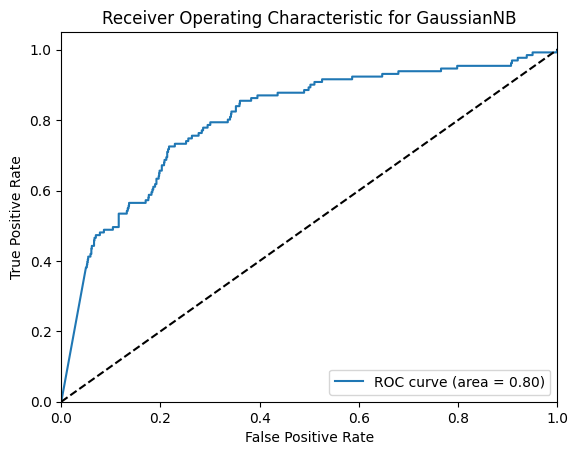


Best Random Forest Classifier with parameters({'classifier__var_smoothing': 2.848035868435799e-05}): 
Accuracy of 0.8302176903779235 and cost -59000


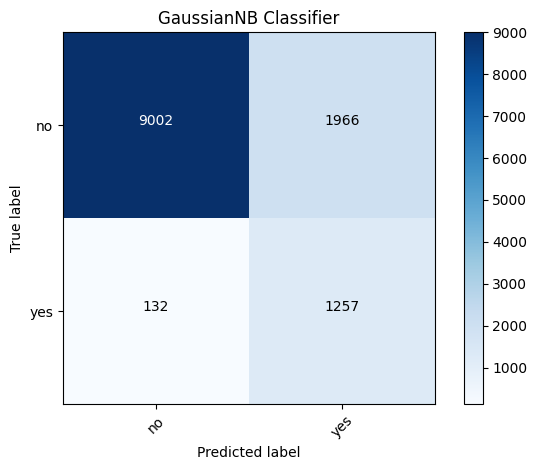

              precision    recall  f1-score   support

          no       0.99      0.82      0.90     10968
         yes       0.39      0.90      0.55      1389

    accuracy                           0.83     12357
   macro avg       0.69      0.86      0.72     12357
weighted avg       0.92      0.83      0.86     12357



In [33]:
#load full datast
bank_data_full = pd.read_csv("Data/bank-additional/bank-additional/bank-additional-full.csv", delimiter=";") 

# Preprocessing of the target data
bank_target_f = bank_data_full['y']
bank_data_f = bank_data_full.drop(columns='y')

label = LabelEncoder()
bank_target_f = label.fit_transform(bank_target_f)
label_names=['no','yes'] # 0 = no, 1 = yes
label_order=label.transform(label_names)

preprocessor = ColumnTransformer(
    transformers=[
        # MinMaxScaler for numerical columns
        ('scaler', preprocessing.MinMaxScaler(), 
            ['age', 'duration', 'campaign', 'pdays', 'previous', 
            'emp.var.rate', 'cons.price.idx', 'cons.conf.idx',  
            'euribor3m', 'nr.employed']),
        # OneHotEncoder for categorical columns
        ('encoder', preprocessing.OneHotEncoder(handle_unknown='ignore'), 
            ['job','marital','education','default','housing',
             'loan','contact','month','day_of_week','poutcome'])])

# creating a new pipeline
new_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('balancing', RandomUnderSampler()),
                              ('classifier', RandomForestClassifier(
                                  criterion='entropy', 
                                  max_depth=7, 
                                  max_features='sqrt', 
                                  n_estimators=100
                              ))])

# split into test and training data
bank_data_f_train, bank_data_f_test, bank_target_f_train, bank_target_f_test = train_test_split(bank_data_f, bank_target_f, test_size=0.3, random_state=42)

# Create and fit model
new_pipeline.fit(bank_data_f_train, bank_target_f_train)

# Make predictions
prediction = new_pipeline.predict(bank_data_f_test)

# Calculate probabilities for the positive class
probs = best_model.predict_proba(bank_data_test)[:, 1]

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(bank_target_test, probs)

# Calculate the AUC
roc_auc = roc_auc_score(bank_target_test, probs)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Random Forest Classifier')
plt.legend(loc="lower right")
plt.show()


# Calculate accuracy and cost
cm = confusion_matrix(bank_target_f_test, prediction)
acc = accuracy_score(bank_target_f_test, prediction)
cost = cost_function(bank_target_f_test, prediction)

# Plot Confusion Matrix
print("\nBest Random Forest Classifier with parameters({}): \nAccuracy of {} and cost {}".format(best_param, acc, cost))
plot_confusion_matrix(cm, classes=label_names, title='Random Forest Classifier')
plt.show()
print(classification_report(bank_target_f_test, prediction, target_names=label_names))

